In [1]:
!pip install mlxtend
import pandas as pd
import numpy as np
 
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,  cross_val_score
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, roc_curve, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report
from sklearn.metrics import make_scorer
from mlxtend.evaluate import lift_score

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as py
from plotly.subplots import make_subplots

import time
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) # to avoid deprecation warnings



# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" # to be replaced by "iframe" if working on JULIE

!pip install -U kaleido

  Using cached mlxtend-0.19.0-py2.py3-none-any.whl (1.3 MB)
  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl (79.9 MB)


In [9]:
data = pd.read_csv("churn_data2.csv") 
#chur_data2 is the dataset to which i added feature "LATEST_TERMS_ACCEPTED_AT" that was provided by the company later during the project

In [10]:
data.shape

(109912, 54)

In [11]:
features = data.columns

In [ ]:
#the following choice of features to keep is based on my own understanding of data and explanations provided by the data science team

In [12]:
features_to_delete = ["AVG_SCORE", "SEGMENT", "SUB_SEGMENT", "CS_OWNER", "LAST_FUNDRAISING_AMOUNT", "HIGH_LOW_TOUCH",#not relevant
                       "ACCOUNTING_EXPORTS_GENERATED", "AMOUNT_SMI_REQ_EUR", #correlated to other varibales
                      "INDUSTRY",'VAR_MRR', "REQUESTER_LOGIN_PER_USER","NON_REQUESTER_LOGIN_PER_USER", 
                      "AVERAGE_TIME_PER_USER_NON_REQUESTER", "AVERAGE_TIME_PER_USER_REQUESTER",
                      "COUNT_PAY_PER_ACTIVE_USERS", "ACTIVE_USERS_PER_FTE", "FIX_MRR","AMOUNT_PLASTIC_CARD_PAYMENTS_EUR", 
                      "NB_SINGLE_PURCHASE_PAYMENTS", "NB_SUBSCRIPTIONS_PAYMENTS", "NB_SMI_REQ"] #redundant or correlated  with similar fetaures 
temp_features = ['MONTH', "NB_ACTIVE_PLASTIC_CARDS", "LOGIN_PER_USER", "AVERAGE_TIME_PER_USER",  
                 'ACTIVE_USERS_PER_USERS', 'AMOUNT_PAY_PER_ACTIVE_USERS', 'NUMBER_EXPORT', 'PAY_PER_LOAD',
                 'USERS_PER_FTE', 'VAR_MRR_PER_FTE', 'AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR', 'AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR',
                 'NUMBER_OF_TEAMS_ACTIVE', 'NB_PLASTIC_CARD_PAYMENTS','SUM_TICKETS', 'SUM_TICKETS_JIRA', 'AMOUNT_EXP_CL_REQ_EUR', 'NB_EXP_CL_REQ']
constant_features = ["ENTITY_ID", "COUNTRY", "AGG_INDUSTRY","IS_FLAGSHIP", "MAIN_ENTITY", "PLAN", "BUNDLE","FIRST_LOAD_DATE", "LAST_LOAD_DATE","CHURNING_DATE",
                     "LATEST_TERMS_ACCEPTED_AT", "NPS", "HEALTHSCORE", "FTE_AGG",  "AGE"]
if len(features_to_delete)+len(temp_features)+len(constant_features)-data.shape [1] == 0:
    print("we're all good")
else:
    print("there are missing features !")

we're all good


In [13]:

set(features) ^ set(features_to_delete+temp_features+constant_features)

set()

## Feature engineering and reformating data 

In [14]:
features_to_keep = constant_features + temp_features
len(features_to_keep)

33

In [15]:
#deleting non relevant features
df = pd.DataFrame(data, columns = features_to_keep)
df.shape

(109912, 33)

In [16]:
#transforming date features into datetime format
df['MONTH'] = pd.to_datetime(df['MONTH'], format='%Y-%m-%d') 
df['FIRST_LOAD_DATE'] = pd.to_datetime(df['FIRST_LOAD_DATE'], format='%Y-%m-%d')
df['LAST_LOAD_DATE'] = pd.to_datetime(df['LAST_LOAD_DATE'], format='%Y-%m-%d %H:%M:%S')
df['CHURNING_DATE'] = pd.to_datetime(df['CHURNING_DATE'], format='%Y-%m-%d %H:%M:%S')
df['LATEST_TERMS_ACCEPTED_AT'] = pd.to_datetime(df['LATEST_TERMS_ACCEPTED_AT'], format='%Y-%m-%d %H:%M:%S')

In [17]:
#creating variable TENURE which indicates for how many days the client have been loading his portfolio 
#creating variable TIME_TO_LOAD which indicates how long it took the client to load his portfolio strating from signature date to first date of load
df["TENURE"] = (df["LAST_LOAD_DATE"] - df["FIRST_LOAD_DATE"]).dt.days
df["TIME_TO_LOAD"] = (df["FIRST_LOAD_DATE"] - df["LATEST_TERMS_ACCEPTED_AT"]).dt.days

In [18]:
#creating target variable : 1 if churning_date not missing 0 otherwise
df['TARGET'] = df['CHURNING_DATE'].fillna(0).apply(lambda x: 0 if x == 0 else 1) 

In [19]:
df.head()

,ENTITY_ID,COUNTRY,AGG_INDUSTRY,IS_FLAGSHIP,MAIN_ENTITY,PLAN,BUNDLE,FIRST_LOAD_DATE,LAST_LOAD_DATE,CHURNING_DATE,...,AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR,NUMBER_OF_TEAMS_ACTIVE,NB_PLASTIC_CARD_PAYMENTS,SUM_TICKETS,SUM_TICKETS_JIRA,AMOUNT_EXP_CL_REQ_EUR,NB_EXP_CL_REQ,TENURE,TIME_TO_LOAD,TARGET
0,viqa4cw1m8g0x3,IT,Others,False,True,Scale,Online,2021-06-30,2022-03-01 16:50:43,NaT,...,3767.9700,NaN,9.0,1.0,NaN,83.00,1.0,244.0,4.0,0
1,vjoc1lr-0bupfj,FR,Others,False,NaN,Standard,Online + Expenses,2020-10-14,2021-12-31 09:06:06,NaT,...,0.0000,7.0,NaN,NaN,NaN,NaN,NaN,443.0,4.0,0
2,vm411wimib5e_x,US,Others,NaN,True,Standard,Online,2021-12-16,2022-01-21 07:01:21,NaT,...,145.7012,2.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN,0
3,vk9kmg_r0mf_0s,MT,Media,True,True,Essentials,Online + Expenses,2020-10-12,2022-01-27 09:22:41,NaT,...,23921.8800,22.0,46.0,NaN,NaN,0.00,0.0,472.0,13.0,0
4,vm3d8ydrpoed3e,DE,Media,False,True,Standard,Suite,2021-03-12,2022-03-08 18:56:17,NaT,...,41.3500,10.0,1.0,2.0,NaN,825.09,26.0,361.0,1.0,0


In [20]:
df.describe(include="all").T

/tmp/ipykernel_70/3091660646.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/tmp/ipykernel_70/3091660646.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/tmp/ipykernel_70/3091660646.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/tmp/ipykernel_70/3091660646.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will b

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ENTITY_ID,109912,6024,E1jzxtOde,75,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COUNTRY,109912,43,FR,60336,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGG_INDUSTRY,107636,4,Others,57145,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IS_FLAGSHIP,91794,2,False,71335,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAIN_ENTITY,59182,1,True,59182,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLAN,93008,7,Standard,37114,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BUNDLE,99933,5,Online + Expenses,57767,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FIRST_LOAD_DATE,109912,1389,2019-09-10 00:00:00,289,2016-01-25 00:00:00,2022-03-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAST_LOAD_DATE,106765,5376,2022-03-05 07:00:06,214,2016-03-10 19:28:43,2022-03-09 09:45:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHURNING_DATE,20615,1403,2022-01-25 09:50:31,66,2016-10-21 14:09:30,2022-03-08 14:41:24,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [22]:
#Proportion of churn in dataset 
px.pie(df,names='TARGET',title='Proportion of churn',hole=0.33) #attention: there are duplicates among clients id for now, we'll manage that later

In [23]:
#Proportion of churn in dataset of clients (no duplicates in entity_id now)
px.pie(pd.DataFrame(df).drop_duplicates(subset=['ENTITY_ID'], keep="last"),names='TARGET',title='Proportion of churn',hole=0.33)

In [24]:
#Proportion of main entity clients 
px.pie(df,names='MAIN_ENTITY',title='Proportion of main entity',hole=0.33)

In [25]:
#re processing main entity : 1 = "TRUE" and "False" = NaN
df['MAIN_ENTITY'] = df['MAIN_ENTITY'].fillna(False)

In [26]:
#a function transforming numerical data with str format into float format when data not missing
def str_tofloat(df, list_var):
  for var in list_var:
    # Replace very low values (quasi equivalent to 0) by 0
    df[var] = df[var].replace('0,00E+00','0').astype(float)
    df[var] = df[var].replace('8,00E-06','0').astype(float)
    # Replace empty string ('') with np.nan if there is any 
    df[var] = df[var].replace('',np.nan).astype(float)
    # Convert each value of the column to a float and ignore the strings where there is a character
    df[var] = pd.to_numeric(df[var], errors='coerce')
  print(df[list_var].dtypes)

In [27]:
#transforming "PAY_PER_LOAD", "USERS_PER_FTE" and "AMOUNT_PAY_PER_ACTIVE_USERS" into float format 
str_tofloat(df, ["PAY_PER_LOAD", "AMOUNT_PAY_PER_ACTIVE_USERS","PAY_PER_LOAD"])

PAY_PER_LOAD                   float64
AMOUNT_PAY_PER_ACTIVE_USERS    float64
PAY_PER_LOAD                   float64
dtype: object


In [28]:
#remove rows with missing last_load_date as it must be a error for every client has a 1rst load date and should hence have a last loading date value.
df = df[df['LAST_LOAD_DATE'].notna()]

In [29]:
df.shape

(106765, 36)

## Creating and saving clean dataset for later job 

In [30]:
#check number of unique clients who have last_load_date not missing
len(df["ENTITY_ID"].unique()) #number of unique clients who have last_load_date not missing

5543

In [31]:
#creating a dataset with unique clients id and their constant features. will be used later in a unsupervised model if time allows it
db_clients = pd.DataFrame(df, columns = constant_features + ["TENURE", "TIME_TO_LOAD", "TARGET"]).drop_duplicates(subset=['ENTITY_ID'], keep="last")

In [32]:
db_clients.shape

(5543, 18)

In [33]:
db_clients.to_csv('db_clients.csv', index=False)

In [34]:
#creating a dataset with unique clients id and last value for each feature observed (ie last month of extraction for each client) 
# it will constitude our client database at time = last month of observation
db_client_allobs = pd.DataFrame(df).drop_duplicates(subset=['ENTITY_ID'], keep="last")

In [35]:
db_client_allobs.shape

(5543, 36)

In [36]:
db_client_allobs.to_csv('dataset_lastobs.csv', index=False)

In [37]:
dataset= db_client_allobs

In [38]:
dataset.describe(include="all").T

/tmp/ipykernel_70/3928026091.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/tmp/ipykernel_70/3928026091.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/tmp/ipykernel_70/3928026091.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.

/tmp/ipykernel_70/3928026091.py:1: FutureWarning:

Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will b

,count,unique,top,freq,first,last,mean,std,min,25%,50%,75%,max
ENTITY_ID,5543,5543,vn4bq3454co39-,1,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
COUNTRY,5543,43,FR,2905,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AGG_INDUSTRY,5348,4,Others,3304,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IS_FLAGSHIP,4498,2,False,3656,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
MAIN_ENTITY,5543,2,False,2892,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PLAN,4463,7,Standard,1615,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BUNDLE,4684,5,Online + Expenses,2308,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN
FIRST_LOAD_DATE,5543,1381,2021-09-17 00:00:00,20,2016-01-25 00:00:00,2022-03-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
LAST_LOAD_DATE,5543,5376,2022-03-05 07:00:06,9,2016-03-10 19:28:43,2022-03-09 09:45:14,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CHURNING_DATE,1168,1168,2018-11-08 09:20:01,1,2016-10-21 14:09:30,2022-03-08 10:05:55,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Exploration and Visualization 

In [39]:
#plotting churn proportion in client database . 
# this shows that the dataset is unbalanced, we need to keep that in mind when analysing models performance
c_labels = ['Retain', 'Churn']
fig = go.Figure(data=[go.Pie(labels=c_labels, 
                             values=dataset['TARGET'].value_counts(), 
                             hole=.3,
                            )
                     ]
               )

fig.update_layout(
    title_text="Churn distribution",
    title_x = 0.5,
    legend=dict(
        orientation="v",
        yanchor="top",
        y=1.0,
        xanchor="left",
        x=1
    ),
    legend_tracegroupgap = 90
    )

config = {'displaylogo': False}
fig.show(config=config)

In [40]:
#client who did not chern dataset
not_churn = dataset[db_clients["TARGET"]==0]

In [41]:
not_churn.shape

(4375, 36)

In [42]:
#client who did chern dataset
churn = dataset[db_clients["TARGET"]==1]

In [43]:
churn.shape

(1168, 36)

In [44]:
#function to plot pie charts for categorical features inspired by https://www.kaggle.com/code/mekhdigakhramanian
def plot_pie(column) :
    
    trace1 = go.Pie(values  = churn[column].value_counts().values.tolist(),
                    labels  = churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    domain  = dict(x = [0,.48]),
                    name    = "Churn Customers",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    hole    = .6
                   )
    trace2 = go.Pie(values  = not_churn[column].value_counts().values.tolist(),
                    labels  = not_churn[column].value_counts().keys().tolist(),
                    hoverinfo = "label+percent+name",
                    marker  = dict(line = dict(width = 2,
                                               color = "rgb(243,243,243)")
                                  ),
                    domain  = dict(x = [.52,1]),
                    hole    = .6,
                    name    = "Non churn customers" 
                   )

    layout = go.Layout(dict(title = column + " distribution",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            annotations = [dict(text = "churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .15, y = .5),
                                           dict(text = "Non churn customers",
                                                font = dict(size = 13),
                                                showarrow = False,
                                                x = .88,y = .5
                                               )
                                          ]
                           )
                      )
    data = [trace1,trace2]
    fig  = go.Figure(data = data,layout = layout)
    py.iplot(fig)

In [45]:
#for all categorical columns we will plot pie the data with differeciation between churn and not churn clients
['COUNTRY', 'AGG_INDUSTRY', 'IS_FLAGSHIP', 'MAIN_ENTITY', 'PLAN', 'BUNDLE']

['COUNTRY', 'AGG_INDUSTRY', 'IS_FLAGSHIP', 'MAIN_ENTITY', 'PLAN', 'BUNDLE']

In [46]:
plot_pie('COUNTRY')

In [47]:
fig = px.histogram(dataset, x="COUNTRY", color=dataset["TARGET"].astype(str))
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [48]:
plot_pie('AGG_INDUSTRY')

In [49]:
fig = px.histogram(dataset, x="AGG_INDUSTRY", color=dataset["TARGET"].astype(str), text_auto=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [50]:
plot_pie('IS_FLAGSHIP')

In [51]:
plot_pie('MAIN_ENTITY') #shows that all churned customers had a missing value for main-entity feature  ! that's interesting to deep dive later

In [52]:
fig = px.histogram(dataset, x="MAIN_ENTITY", color=dataset["TARGET"].astype(str), text_auto=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [53]:
plot_pie('PLAN')

In [54]:
fig = px.histogram(dataset, x="PLAN", color=dataset["TARGET"].astype(str), text_auto=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [55]:
plot_pie('BUNDLE')

In [56]:
#plotting age clients distribution : age equals number of months between first load and last month extraction according to data science team
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=db_clients['AGE'],name='AGe Box Plot',boxmean=True)
tr2=go.Histogram(x=db_clients['AGE'],name='Age Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of Client Age")
fig.show()

In [57]:
#plotting tenure clients distribution : age equals delat between first load and last load
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=db_clients['TENURE'],name='Tenure Box Plot',boxmean=True)
tr2=go.Histogram(x=db_clients['TENURE'],name='Tenue Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=700, width=1200, title_text="Distribution of Client Tenure")
fig.show()

In [59]:
#Distribution of NPS
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=dataset['NPS'],name='NPS Box Plot',boxmean=True)
tr2=go.Histogram(x=dataset['NPS'],name='NPS Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=500, width=1000, title_text="Distribution of Client NPS")
fig.show()
#this shows many outliers too !

In [60]:
#Distribution of HEALTHSCORE
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=dataset['HEALTHSCORE'],name='HEALTHSCORE Box Plot',boxmean=True)
tr2=go.Histogram(x=dataset['HEALTHSCORE'],name='HEALTHSCORE Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=500, width=1000, title_text="Distribution of HEALTHSCORE")
fig.show()

In [61]:
#function to plot histogram charts for numeric features inspired by https://www.kaggle.com/code/mekhdigakhramanian
def histogram(column) :
    trace1 = go.Histogram(x  = churn[column],
                          histnorm= "percent",
                          name = "Churn Customers",
                          marker = dict(line = dict(width = .5,
                                                    color = "black"
                                                    )
                                        ),
                         opacity = .9 
                         ) 
    
    trace2 = go.Histogram(x  = not_churn[column],
                          histnorm = "percent",
                          name = "Non churn customers",
                          marker = dict(line = dict(width = .5,
                                              color = "black"
                                             )
                                 ),
                          opacity = .9
                         )
    
    data = [trace1,trace2]
    layout = go.Layout(dict(title =column + " distribution",
                            plot_bgcolor  = "rgb(243,243,243)",
                            paper_bgcolor = "rgb(243,243,243)",
                            xaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = column,
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                            yaxis = dict(gridcolor = 'rgb(255, 255, 255)',
                                             title = "percent",
                                             zerolinewidth=1,
                                             ticklen=5,
                                             gridwidth=2
                                            ),
                           )
                      )
    fig  = go.Figure(data=data,layout=layout)
    
    py.iplot(fig)

In [64]:
histogram("TIME_TO_LOAD") 
#the latest date of signature wich was used to create time_to_load feature is problematic or with a bad comprehension as shown below :
# I was not expecting time to load to have negative values !
#need to check it later with the data science team. For now we keep for it for the base model

In [65]:
histogram("TENURE")

In [66]:
histogram("AGE")

In [67]:
histogram("HEALTHSCORE")

In [68]:
fig = px.histogram(dataset, x="HEALTHSCORE", color=dataset["TARGET"].astype(str), text_auto=True)
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

In [69]:
histogram("NPS")

In [70]:
histogram("AMOUNT_EXP_CL_REQ_EUR")

In [71]:
histogram("LOGIN_PER_USER")

In [72]:
histogram("NUMBER_EXPORT")

In [73]:
histogram("USERS_PER_FTE")

In [74]:
#distribution of AVERAGE_TIME_PER_USER by the client
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=dataset['AVERAGE_TIME_PER_USER'],name='AVERAGE_TIME_PER_USER Box Plot',boxmean=True)
tr2=go.Histogram(x=dataset['AVERAGE_TIME_PER_USER'],name='AVERAGE_TIME_PER_USER Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=500, width=1000, title_text="Distribution of average time per user per client")
fig.show()

In [75]:
#distribution of number of plastic card payment by the client
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=dataset['NB_PLASTIC_CARD_PAYMENTS'],name='NB_PLASTIC_CARD_PAYMENTS Box Plot',boxmean=True)
tr2=go.Histogram(x=dataset['NB_PLASTIC_CARD_PAYMENTS'],name='NB_PLASTIC_CARD_PAYMENTS Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=500, width=1000, title_text="Distribution of number of plastic card payments per client")
fig.show()

In [76]:
#Distribution of amount of expenses claims per client
fig = make_subplots(rows=2, cols=1)

tr1=go.Box(x=dataset['AMOUNT_EXP_CL_REQ_EUR'],name='AMOUNT_EXP_CL_REQ_EUR Box Plot',boxmean=True)
tr2=go.Histogram(x=dataset['AMOUNT_EXP_CL_REQ_EUR'],name='AMOUNT_EXP_CL_REQ_EUR Histogram')

fig.add_trace(tr1,row=1,col=1)
fig.add_trace(tr2,row=2,col=1)

fig.update_layout(height=500, width=1000, title_text="Distribution of amount of expenses claims per client")
fig.show()

In [77]:
fig = px.histogram(dataset, x="TENURE", color=dataset["TARGET"].astype(str))
fig.update_layout(
    autosize=False,
    width=600,
    height=500,
    margin=dict(
        l=50,
        r=50,
        b=100,
        t=100,
        pad=4
    ),
    paper_bgcolor="LightSteelBlue",
)
fig.show()

## Pre processing data with SKlearn in view of training ML models

In [78]:
# Drop useless columns for training a model from dataset (reminder : I chose to keep the observations/unique client spotted at last extract month for each client)
useless_cols = ['ENTITY_ID', 'MONTH', "FIRST_LOAD_DATE", "LAST_LOAD_DATE", "CHURNING_DATE", 'LATEST_TERMS_ACCEPTED_AT']

print("Dropping useless columns...")
dataset = dataset.drop(useless_cols, axis=1) # axis = 1 indicates that we are dropping along the column axis
print("...Done.")
print(dataset.head())

Dropping useless columns...
...Done.
    COUNTRY AGG_INDUSTRY IS_FLAGSHIP  MAIN_ENTITY        PLAN  \
363      US       Others        True        False       Scale   
560      FR       Others        True        False        Lite   
569      FR       Others       False        False        Lite   
600      US       Others         NaN         True    Standard   
693      FR       Others       False        False  Essentials   

                BUNDLE    NPS  HEALTHSCORE  FTE_AGG  AGE  ...  \
363             Online   59.0          NaN       97    1  ...   
560             Online   33.0         65.0        7    2  ...   
569  Online + Expenses    NaN          NaN        8    1  ...   
600             Online    NaN         90.0      439    0  ...   
693             Online  100.0         90.0        9    2  ...   

     AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR  NUMBER_OF_TEAMS_ACTIVE  \
363                           330.9624                     NaN   
560                           401.9800           

In [79]:
# Separate target variable Y from features X
target_name = 'TARGET'

print("Separating labels from features...")
Y = dataset.loc[:,target_name]
X = dataset.loc[:,[c for c in dataset.columns if c!=target_name]] # All columns are kept, except the target
print("...Done.")

Separating labels from features...
...Done.


In [80]:
print(type(X))
print(type(Y))

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.series.Series'>


In [81]:
print(X.shape)
print(dataset.shape)

(5543, 29)
(5543, 30)


### Preprocessing - Scikit-Learn

In [82]:
# Automatically detect positions of numeric/categorical features
idx = 0
numeric_features = []
numeric_indices = []
categorical_features = []
categorical_indices = []
for i,t in X.dtypes.iteritems():
    if ('float' in str(t)) or ('int' in str(t)) :
        numeric_features.append(i)
        numeric_indices.append(idx)
    else :
        categorical_features.append(i)
        categorical_indices.append(idx)

    idx = idx + 1

print('Found numeric features ', numeric_features,' at positions ', numeric_indices)
print('Found categorical features ', categorical_features,' at positions ', categorical_indices)

Found numeric features  ['NPS', 'HEALTHSCORE', 'FTE_AGG', 'AGE', 'NB_ACTIVE_PLASTIC_CARDS', 'LOGIN_PER_USER', 'AVERAGE_TIME_PER_USER', 'ACTIVE_USERS_PER_USERS', 'AMOUNT_PAY_PER_ACTIVE_USERS', 'NUMBER_EXPORT', 'PAY_PER_LOAD', 'USERS_PER_FTE', 'VAR_MRR_PER_FTE', 'AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR', 'AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR', 'NUMBER_OF_TEAMS_ACTIVE', 'NB_PLASTIC_CARD_PAYMENTS', 'SUM_TICKETS', 'SUM_TICKETS_JIRA', 'AMOUNT_EXP_CL_REQ_EUR', 'NB_EXP_CL_REQ', 'TENURE', 'TIME_TO_LOAD']  at positions  [6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]
Found categorical features  ['COUNTRY', 'AGG_INDUSTRY', 'IS_FLAGSHIP', 'MAIN_ENTITY', 'PLAN', 'BUNDLE']  at positions  [0, 1, 2, 3, 4, 5]


In [83]:
#checking if there are outliers among categorical features 

In [84]:
#a function that find and put in "other" category the outliers. we consider outliers a mode with an occurence less than 1%"
def replace_outliers(df, var):
    occurence = 100*dataset[var].value_counts()/dataset[var] .notnull().sum()
    lowest = [i for i in occurence.index if occurence[i]<1]
    df[var]=df[var].apply(lambda x: x if x not in lowest else "OTHER")

In [85]:
replace_outliers(X, "COUNTRY")

In [86]:
replace_outliers(X, "PLAN")

In [87]:
replace_outliers(X, "BUNDLE")

In [88]:
replace_outliers(X, "AGG_INDUSTRY")

In [89]:
X.head()

,COUNTRY,AGG_INDUSTRY,IS_FLAGSHIP,MAIN_ENTITY,PLAN,BUNDLE,NPS,HEALTHSCORE,FTE_AGG,AGE,...,AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR,AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR,NUMBER_OF_TEAMS_ACTIVE,NB_PLASTIC_CARD_PAYMENTS,SUM_TICKETS,SUM_TICKETS_JIRA,AMOUNT_EXP_CL_REQ_EUR,NB_EXP_CL_REQ,TENURE,TIME_TO_LOAD
363,US,Others,True,False,Scale,Online,59.0,NaN,97,1,...,5886.8204,330.9624,NaN,1.0,1.0,NaN,12.50,1.0,27.0,NaN
560,FR,Others,True,False,Lite,Online,33.0,65.0,7,2,...,780.9200,401.9800,NaN,5.0,3.0,NaN,NaN,NaN,118.0,NaN
569,FR,Others,False,False,Lite,Online + Expenses,NaN,NaN,8,1,...,NaN,NaN,NaN,2.0,12.0,3.0,NaN,NaN,19.0,NaN
600,US,Others,NaN,True,Standard,Online,NaN,90.0,439,0,...,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,36.0,NaN
693,FR,Others,False,False,Essentials,Online,100.0,90.0,9,2,...,2961.9200,0.0000,NaN,32.0,2.0,NaN,302.32,10.0,122.0,NaN


In [90]:
# Divide dataset in Train set & Test set 
print("Dividing into train and test sets...")
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42, stratify = Y)
print("...Done.")
print()

Dividing into train and test sets...
...Done.



#### Training pipeline

In [91]:
# numeric transformation 
numeric_transformer = Pipeline(
    steps=[
        ("num_imputer", SimpleImputer(strategy="median")), #missing values will be replaced by "median" 
        ("num_scaler", StandardScaler())
    ]
)

# OHE / dummyfication & simpleimputer 
categorical_transformer = Pipeline(
    steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # missing values will be replaced by "most frequent" value.
    ('encoder', OneHotEncoder(drop='first')) # first column will be dropped to avoid creating correlations between features
    ])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_indices),    
        ('num', numeric_transformer, numeric_indices)
        ]
    )

X_train = preprocessor.fit_transform(X_train)
print("...Done")
print(X_train[0:5,:])


...Done
[[ 0.          0.          0.          1.          0.          0.
   0.          1.          0.          0.          0.          0.
   0.          0.          0.          1.          0.          0.
   1.          0.          0.          0.          1.22818651 -1.92915467
  -0.03647863 -0.38572256 -0.39863554 -0.21946426  0.09647521  0.59497637
  -0.02559895 -0.15668461 -0.04604884  0.319312    0.01460921 -0.11759565
  -0.25962547 -0.62510367 -0.23415478 -0.12708206 -0.15008572 -0.1624987
  -0.11209129 -0.28825337 -2.58710001]
 [ 0.          0.          1.          0.          0.          0.
   0.          1.          0.          0.          1.          0.
   0.          0.          1.          0.          0.          0.
   1.          0.          0.          0.          1.22818651  0.28881358
  -0.0356944  -0.09409578 -0.29046896 -0.30090732 -0.14125342 -0.63032869
  -0.02009716  0.69081715 -0.04654116  0.77245059 -0.00799416 -0.28021747
  -0.20555518 -0.62510367 -0.21633057  0

In [92]:
## Getting names of features after preprocessing for more clarity later in the project when comparinf models performances
#a function found a forum discussion (https://datascience.stackexchange.com/questions/100583)
def get_feature_names(preprocessor):  
        
        #column_transformer = preprocessor      

        new_feature_names = []

        for i, transformer_item in enumerate(preprocessor.transformers_): 
            
            transformer_name, transformer, orig_feature_names = transformer_item
            orig_feature_names = list(orig_feature_names)
                
            if isinstance(transformer, Pipeline):
                # if pipeline, get the last transformer in the Pipeline
                transformer = transformer.steps[-1][1]

            if hasattr(transformer, 'get_feature_names'):

                if 'input_features' in transformer.get_feature_names.__code__.co_varnames:

                    names = list(transformer.get_feature_names(orig_feature_names))

                else:

                    names = list(transformer.get_feature_names())


            new_feature_names.extend(names)
        
        return new_feature_names

In [93]:
#the first 22 elements are the categorical features with all their modes after preprocessing
get_feature_names(preprocessor)[:22]

/opt/conda/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning:

Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.



['x0_DE',
 'x0_ES',
 'x0_FR',
 'x0_GB',
 'x0_NL',
 'x0_OTHER',
 'x0_US',
 'x1_Others',
 'x1_Retail',
 'x1_Tech',
 'x2_True',
 'x3_True',
 'x4_Lite',
 'x4_OTHER',
 'x4_Scale',
 'x4_Standard',
 'x4_Starter',
 'x4_not migrated yet',
 'x5_Online + Expenses',
 'x5_Online + Invoices',
 'x5_Suite',
 'x5_not migrated yet']

In [94]:
#getting catgeorical features names back
feature_names = []
print(len(numeric_features) + len(get_feature_names(preprocessor)[:22]) - X_train.shape[1]) #checking we have the same number of features as in X_train
for i in range(len(get_feature_names(preprocessor)[:22])): #getting categorical features names per categorie
    feature_names.append(get_feature_names(preprocessor)[:22][i])
feature_names = feature_names + numeric_features
print(feature_names)

0
['x0_DE', 'x0_ES', 'x0_FR', 'x0_GB', 'x0_NL', 'x0_OTHER', 'x0_US', 'x1_Others', 'x1_Retail', 'x1_Tech', 'x2_True', 'x3_True', 'x4_Lite', 'x4_OTHER', 'x4_Scale', 'x4_Standard', 'x4_Starter', 'x4_not migrated yet', 'x5_Online + Expenses', 'x5_Online + Invoices', 'x5_Suite', 'x5_not migrated yet', 'NPS', 'HEALTHSCORE', 'FTE_AGG', 'AGE', 'NB_ACTIVE_PLASTIC_CARDS', 'LOGIN_PER_USER', 'AVERAGE_TIME_PER_USER', 'ACTIVE_USERS_PER_USERS', 'AMOUNT_PAY_PER_ACTIVE_USERS', 'NUMBER_EXPORT', 'PAY_PER_LOAD', 'USERS_PER_FTE', 'VAR_MRR_PER_FTE', 'AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR', 'AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR', 'NUMBER_OF_TEAMS_ACTIVE', 'NB_PLASTIC_CARD_PAYMENTS', 'SUM_TICKETS', 'SUM_TICKETS_JIRA', 'AMOUNT_EXP_CL_REQ_EUR', 'NB_EXP_CL_REQ', 'TENURE', 'TIME_TO_LOAD']


In [95]:
#a function to get model performances in a nutshell
def perf_model(algorithm, X_train, X_test, Y_train, Y_test, Y_train_pred, Y_test_pred) :
    
    #display model caracteristics
    print (algorithm)
    
    #display scores
    print(f"accuracy on train set: {round(accuracy_score(Y_train, Y_train_pred)*100, 1)} %")
    print(f"accuracy on test set : {round(accuracy_score(Y_test, Y_test_pred)*100, 1)} %")
   
    print(f"f1-score on train set: {round(f1_score(Y_train, Y_train_pred)*100, 1)} %")
    print(f"f1-score on test set: {round(f1_score(Y_test, Y_test_pred)*100, 1)} %")
    
    print(f"Lift score on train set: {round(lift_score(Y_train, Y_train_pred), 1)}")
    print(f"Lift score on test set: {round(lift_score(Y_test, Y_test_pred), 1)}")
    
    #display classification report on test set 
    print ("\n Classification report : \n",classification_report(Y_test,Y_test_pred))
    print ("Accuracy   Score : ",accuracy_score(Y_test,Y_test_pred))
    
    # Visualize confusion matrices on test set
    _ , ax = plt.subplots() # Get subplot from matplotlib
    ax.set(title="Confusion Matrix on Test set") # Set a title that we will add into ConfusionMatrixDisplay
    ConfusionMatrixDisplay.from_estimator(algorithm, X_test, Y_test, ax=ax) # ConfusionMatrixDisplay from sklearn
    plt.show()
    
    # Visualize ROC curves
    probas_train = algorithm.predict_proba(X_train)[:,1]
    precisions, recalls, thresholds = roc_curve(Y_train, probas_train)
    fig = go.Figure(
        data = go.Scatter(
            name = 'train',
            x = recalls, 
            y = precisions, 
            mode = 'lines'
        ),
        layout = go.Layout(
            title = go.layout.Title(text = "ROC curve", x = 0.5),
            xaxis = go.layout.XAxis(title = 'False Positive Rate'),
            yaxis = go.layout.YAxis(title = 'True Positive Rate')
        )
    )

    probas_test = algorithm.predict_proba(X_test)[:,1]
    precisions, recalls, thresholds = roc_curve(Y_test, probas_test)
    fig.add_trace(go.Scatter(
        name = 'test',
        x = recalls, 
        y = precisions, 
        mode = 'lines'
        )
    )
    fig.show()

## Base Model : Logictic regression

In [96]:
# Train model
print("Train model...")
LG = LogisticRegression()
LG.fit(X_train, Y_train)
print("...Done.")

Train model...
...Done.


In [97]:
# Predictions on training set
print("Predictions on training set...")
Y_train_pred = LG.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()

Predictions on training set...
...Done.
[1 0 1 ... 1 1 1]



#### Testing pipeline

In [98]:
# Encoding categorical features and standardizing numerical features
print("Encoding categorical features and standardizing numerical features...")
print(X_test.head())
X_test = preprocessor.transform(X_test)
print("...Done")
print(X_test[0:5,:])

Encoding categorical features and standardizing numerical features...
      COUNTRY AGG_INDUSTRY IS_FLAGSHIP  MAIN_ENTITY        PLAN  \
70963      FR       Others       False         True        Lite   
47117      DE       Retail         NaN        False         NaN   
58245      FR         Tech         NaN        False         NaN   
22977      FR          NaN        True        False    Standard   
73727      DE       Others       False         True  Essentials   

                  BUNDLE   NPS  HEALTHSCORE  FTE_AGG  AGE  ...  \
70963  Online + Expenses -33.0         65.0       20    5  ...   
47117                NaN   NaN         65.0       43    1  ...   
58245                NaN   NaN         25.0      151    1  ...   
22977  Online + Expenses  50.0          NaN        8    8  ...   
73727             Online   NaN         65.0       23    0  ...   

       AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR  AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR  \
70963                                  NaN       

In [99]:
# Predictions on train set
print("Predictions on train set...")
Y_traint_pred = LG.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = LG.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on train set...
...Done.
[1 0 1 ... 1 1 1]

Predictions on test set...
...Done.
[0 1 1 ... 0 0 1]



LogisticRegression()
accuracy on train set: 95.6 %
accuracy on test set : 95.1 %
f1-score on train set: 89.1 %
f1-score on test set: 87.6 %
Lift score on train set: 4.4
Lift score on test set: 4.5

 Classification report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       875
           1       0.95      0.82      0.88       234

    accuracy                           0.95      1109
   macro avg       0.95      0.90      0.92      1109
weighted avg       0.95      0.95      0.95      1109

Accuracy   Score :  0.951307484220018


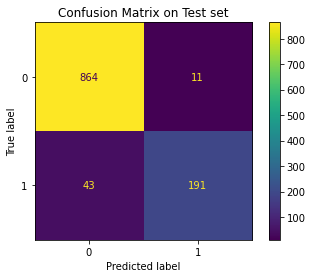

In [100]:
perf_model(LG, X_train, X_test, Y_train, Y_test, Y_train_pred, Y_test_pred)

In [101]:
#the model learn well but slightly overfits according to F1_score. 
# It also predicts more false neagtivex, our goal is to lower the False Negatives hence to get better Recall

#### Regularization with grid-search cross-validation

In [102]:
# we perform 3-fold cross-validation grid search to to regularize the logistic regression model 
grid={"C":np.logspace(-3,3,5), "penalty":["l1","l2"]}# l1 lasso, l2 ridge and C is the inverse of regularization strength
LR_CV = GridSearchCV(LG,grid,cv=3, scoring="f1")
LR_CV.fit(X_train, Y_train)
print("tuned hpyerparameters :(best parameters) ",LR_CV.best_params_)
print(f"accuracy after cross-validation on test set: {round(LR_CV.score(X_test, Y_test)*100, 1)} %")
print(f"f1-score after cross-validation on test set: {round(LR_CV.score(X_test, Y_test)*100, 1)} %")


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression

/opt/conda/lib/python3.9/site-packages/sklearn/lin

tuned hpyerparameters :(best parameters)  {'C': 31.622776601683793, 'penalty': 'l2'}
accuracy after cross-validation on test set: 88.1 %
f1-score after cross-validation on test set: 88.1 %


/opt/conda/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



In [103]:
# Predictions on train set
print("Predictions on train set...")
Y_traint_pred = LR_CV.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = LR_CV.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on train set...
...Done.
[1 0 1 ... 1 1 1]

Predictions on test set...
...Done.
[0 1 1 ... 0 0 1]



GridSearchCV(cv=3, estimator=LogisticRegression(),
             param_grid={'C': array([1.00000000e-03, 3.16227766e-02, 1.00000000e+00, 3.16227766e+01,
       1.00000000e+03]),
                         'penalty': ['l1', 'l2']},
             scoring='f1')
accuracy on train set: 95.6 %
accuracy on test set : 95.3 %
f1-score on train set: 89.1 %
f1-score on test set: 88.1 %
Lift score on train set: 4.4
Lift score on test set: 4.5

 Classification report : 
               precision    recall  f1-score   support

           0       0.95      0.99      0.97       875
           1       0.95      0.82      0.88       234

    accuracy                           0.95      1109
   macro avg       0.95      0.90      0.93      1109
weighted avg       0.95      0.95      0.95      1109

Accuracy   Score :  0.9531109107303878


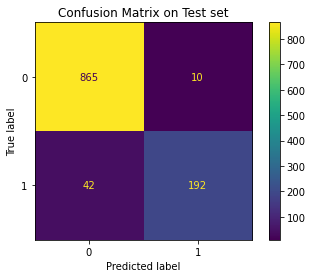

In [104]:
perf_model(LR_CV, X_train, X_test, Y_train, Y_test, Y_train_pred, Y_test_pred)

In [105]:
# get coefs of cv regularized logistic regression
model = LR_CV.best_estimator_
coef = model.coef_.ravel() 
# summarize feature coef
dict = {}
for i,v in enumerate(coef):
    dict["feature"]= feature_names[i]
    dict["coef"] = v
    print(dict)
    #print(feature_names[i]+' : %0d, Score: %.5f' % (i,v))

df = pd.DataFrame({"Feature": feature_names,"LG Coef": coef}).sort_values(by=['LG Coef'])
fig = px.bar(df, x="Feature", y="LG Coef")
fig.show()    


{'feature': 'x0_DE', 'coef': 0.6702129776410881}
{'feature': 'x0_ES', 'coef': 0.27392844398403193}
{'feature': 'x0_FR', 'coef': 0.34870097414532225}
{'feature': 'x0_GB', 'coef': 1.281864781395485}
{'feature': 'x0_NL', 'coef': 1.1331897457915237}
{'feature': 'x0_OTHER', 'coef': 0.9376442266953009}
{'feature': 'x0_US', 'coef': -0.5030325475413434}
{'feature': 'x1_Others', 'coef': -1.0250001353365599}
{'feature': 'x1_Retail', 'coef': -0.19987807844819208}
{'feature': 'x1_Tech', 'coef': -0.010538721753526582}
{'feature': 'x2_True', 'coef': -1.9204726370722185}
{'feature': 'x3_True', 'coef': -10.39905036852629}
{'feature': 'x4_Lite', 'coef': 1.343657728701548}
{'feature': 'x4_OTHER', 'coef': -0.48005013787373135}
{'feature': 'x4_Scale', 'coef': -0.5367652846057341}
{'feature': 'x4_Standard', 'coef': 3.321356195214067}
{'feature': 'x4_Starter', 'coef': -1.3103680307460497}
{'feature': 'x4_not migrated yet', 'coef': -0.9803432998167076}
{'feature': 'x5_Online + Expenses', 'coef': -1.110269152

In [104]:
#X_3 true ( Main entity = True) is the feature with most negative coef. 
#knowing that we had to reprocess this variable we should get back to the company and investigate furthermore this matter
#Not migrated is the feature with the most positive coef. It may make sense as the fintech changed their technology and many clients did not follow the upgrade 

In [106]:
#getting permutation feature importance of the best param model
r = permutation_importance(LR_CV, X_train, Y_train, n_repeats=30,  random_state=0)
                                                       
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i] :<8}"
             f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

x3_True 0.350 +/- 0.013
x4_Standard0.114 +/- 0.007
HEALTHSCORE0.111 +/- 0.007
TENURE  0.072 +/- 0.006
TIME_TO_LOAD0.069 +/- 0.006
x2_True 0.019 +/- 0.004
USERS_PER_FTE0.015 +/- 0.004
x4_Lite 0.015 +/- 0.003
x5_Online + Expenses0.015 +/- 0.003
x5_Suite0.013 +/- 0.002
x1_Others0.012 +/- 0.004
x5_not migrated yet0.010 +/- 0.002
x0_GB   0.008 +/- 0.003
LOGIN_PER_USER0.007 +/- 0.002
x0_DE   0.006 +/- 0.002
x0_OTHER0.005 +/- 0.002


## Random Forest model
Let's train a Random Forest (with hyperparameter optimization) and evaluate its performances compared to logistic gregression

In [107]:
#instanciate a random forest classifier
RF = RandomForestClassifier()

In [108]:
# Perform grid search
print("Grid search...")
# Grid of values to be tested
params = {
    'max_depth': [2, 4, 6, 8, 10],
    'min_samples_leaf': [1, 2, 5],
    'min_samples_split': [2, 4, 8],
    'n_estimators': [20, 40, 60, 80, 100]
}
gridsearch = GridSearchCV(RF, param_grid = params, cv = 3) # cv : the number of folds to be used for CV
gridsearch.fit(X_train, Y_train)
print("...Done.")
print("Best hyperparameters : ", gridsearch.best_params_)
print("Best validation accuracy : ", gridsearch.best_score_)

Grid search...
...Done.
Best hyperparameters :  {'max_depth': 10, 'min_samples_leaf': 2, 'min_samples_split': 8, 'n_estimators': 40}
Best validation accuracy :  0.9553450608930988


In [109]:
#the accuracy is around 0.95 like logistic regression
#now we will get performances of the best random forest estimator 
RFC = gridsearch.best_estimator_

# Predictions on train set
print("Predictions on train set...")
Y_train_pred = RFC.predict(X_train)
print("...Done.")
print(Y_train_pred)
print()
# Predictions on test set
print("Predictions on test set...")
Y_test_pred = RFC.predict(X_test)
print("...Done.")
print(Y_test_pred)
print()

Predictions on train set...
...Done.
[1 0 0 ... 1 1 1]

Predictions on test set...
...Done.
[0 1 1 ... 0 0 1]



RandomForestClassifier(max_depth=10, min_samples_leaf=2, min_samples_split=8,
                       n_estimators=40)
accuracy on train set: 97.3 %
accuracy on test set : 96.0 %
f1-score on train set: 93.3 %
f1-score on test set: 89.7 %
Lift score on train set: 4.7
Lift score on test set: 4.7

 Classification report : 
               precision    recall  f1-score   support

           0       0.95      1.00      0.98       875
           1       0.99      0.82      0.90       234

    accuracy                           0.96      1109
   macro avg       0.97      0.91      0.94      1109
weighted avg       0.96      0.96      0.96      1109

Accuracy   Score :  0.9603246167718665


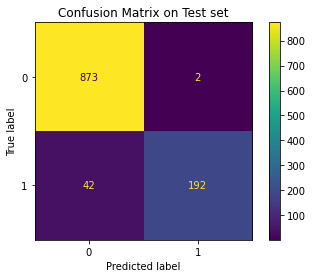

In [111]:
perf_model(RFC, X_train, X_test, Y_train, Y_test, Y_train_pred, Y_test_pred)
# we have slightly the same performance as LG model, but the False Positive is way lower

<AxesSubplot:>

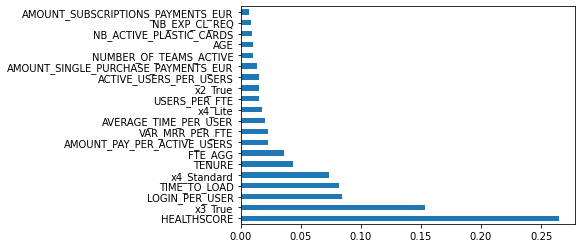

In [112]:
#plotting the 20 first most important features
pd.Series(RFC.feature_importances_, feature_names).nlargest(20).plot(kind='barh')
#healthscoe is the most important feature with RFC !

In [113]:
importance = RFC.feature_importances_
df = pd.DataFrame({"Feature": feature_names,"Feature importance": importance}).sort_values(by=['Feature importance'])
fig = px.bar(df, x="Feature", y="Feature importance")
fig.show()  

In [114]:
#Getting permutation feature importance so we can compare them to logistic regression model ones
r = permutation_importance(RFC, X_train, Y_train, n_repeats=30,  random_state=0, scoring="accuracy")                                     
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{feature_names[i] :<8}"
             f"{r.importances_mean[i]:.3f}"
            f" +/- {r.importances_std[i]:.3f}")

x3_True 0.083 +/- 0.003
HEALTHSCORE0.061 +/- 0.003
x4_Standard0.017 +/- 0.001
LOGIN_PER_USER0.013 +/- 0.001
TIME_TO_LOAD0.010 +/- 0.001
TENURE  0.008 +/- 0.001
VAR_MRR_PER_FTE0.007 +/- 0.001
AVERAGE_TIME_PER_USER0.006 +/- 0.001
FTE_AGG 0.005 +/- 0.001
USERS_PER_FTE0.005 +/- 0.001
x2_True 0.005 +/- 0.001
AMOUNT_PAY_PER_ACTIVE_USERS0.004 +/- 0.001
ACTIVE_USERS_PER_USERS0.004 +/- 0.001
x4_Lite 0.003 +/- 0.001
NUMBER_OF_TEAMS_ACTIVE0.003 +/- 0.001
x1_Others0.002 +/- 0.001
AMOUNT_SINGLE_PURCHASE_PAYMENTS_EUR0.002 +/- 0.001
AGE     0.002 +/- 0.001
NB_PLASTIC_CARD_PAYMENTS0.002 +/- 0.001
AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR0.002 +/- 0.001
NB_ACTIVE_PLASTIC_CARDS0.002 +/- 0.001
NB_EXP_CL_REQ0.002 +/- 0.001
AMOUNT_EXP_CL_REQ_EUR0.001 +/- 0.000
x1_Tech 0.001 +/- 0.000
SUM_TICKETS0.001 +/- 0.001
x4_Scale0.001 +/- 0.000
PAY_PER_LOAD0.001 +/- 0.000
NPS     0.001 +/- 0.000
x0_FR   0.001 +/- 0.001
x0_GB   0.001 +/- 0.000
x5_Online + Expenses0.001 +/- 0.000
NUMBER_EXPORT0.001 +/- 0.000
x0_ES   0.001 +/- 

In [115]:
#let's check the correlatin matrix to make sure that the most important features are not correlated with the target 
corr_matrix = dataset.corr()
corr_matrix

,MAIN_ENTITY,NPS,HEALTHSCORE,FTE_AGG,AGE,NB_ACTIVE_PLASTIC_CARDS,LOGIN_PER_USER,AVERAGE_TIME_PER_USER,ACTIVE_USERS_PER_USERS,AMOUNT_PAY_PER_ACTIVE_USERS,...,AMOUNT_SUBSCRIPTIONS_PAYMENTS_EUR,NUMBER_OF_TEAMS_ACTIVE,NB_PLASTIC_CARD_PAYMENTS,SUM_TICKETS,SUM_TICKETS_JIRA,AMOUNT_EXP_CL_REQ_EUR,NB_EXP_CL_REQ,TENURE,TIME_TO_LOAD,TARGET
MAIN_ENTITY,1.000000,0.045545,0.283091,0.003128,0.121316,0.156905,-0.236819,0.007249,0.034262,0.014788,...,0.096462,0.192509,0.140136,-0.103912,-0.068136,0.025137,0.031870,0.237565,0.123021,-0.494696
NPS,0.045545,1.000000,0.113389,0.005088,0.046982,0.002920,-0.000136,0.010422,0.029682,-0.032504,...,0.045991,0.009434,-0.023143,0.026899,-0.011676,0.014361,0.016105,0.093662,-0.012640,-0.098476
HEALTHSCORE,0.283091,0.113389,1.000000,0.007297,0.044960,0.103226,0.070820,-0.034469,-0.086638,0.006229,...,0.070121,0.139008,0.072416,0.055411,0.039418,0.060333,0.064731,0.126386,0.362667,-0.634558
FTE_AGG,0.003128,0.005088,0.007297,1.000000,0.000072,0.002613,-0.038600,-0.006037,0.000467,-0.001056,...,0.075963,0.018966,0.017579,-0.004638,-0.007393,0.017700,0.021755,-0.000319,-0.016176,0.017190
AGE,0.121316,0.046982,0.044960,0.000072,1.000000,0.208310,-0.165178,-0.015674,0.048896,-0.004806,...,0.095092,0.189742,0.067176,-0.005883,0.043937,-0.000154,0.001603,0.687954,-0.409022,-0.078075
NB_ACTIVE_PLASTIC_CARDS,0.156905,0.002920,0.103226,0.002613,0.208310,1.000000,-0.105685,-0.045140,0.063503,-0.008180,...,0.126365,0.322485,0.587342,0.113111,0.119641,0.110863,0.128666,0.196582,-0.002103,-0.105316
LOGIN_PER_USER,-0.236819,-0.000136,0.070820,-0.038600,-0.165178,-0.105685,1.000000,0.111701,0.062195,0.024115,...,0.267436,-0.102417,-0.012851,0.090440,0.065950,-0.009387,-0.000134,-0.141554,0.126010,-0.018035
AVERAGE_TIME_PER_USER,0.007249,0.010422,-0.034469,-0.006037,-0.015674,-0.045140,0.111701,1.000000,0.010760,0.007974,...,0.182853,-0.026803,-0.026722,-0.024681,-0.023954,-0.000068,-0.012347,-0.018786,-0.000084,0.039496
ACTIVE_USERS_PER_USERS,0.034262,0.029682,-0.086638,0.000467,0.048896,0.063503,0.062195,0.010760,1.000000,-0.011146,...,0.019818,0.047695,0.144716,-0.032103,0.013016,0.008798,0.039759,0.234259,-0.234350,0.143358
AMOUNT_PAY_PER_ACTIVE_USERS,0.014788,-0.032504,0.006229,-0.001056,-0.004806,-0.008180,0.024115,0.007974,-0.011146,1.000000,...,0.413913,0.002946,-0.003491,0.022289,0.025567,0.017821,0.007559,-0.009952,0.016818,-0.009503


In [116]:
corr_matrix = dataset.corr()

fig = go.Figure(
    data = go.Heatmap(
        name = 'test',
        x = corr_matrix.columns, 
        y = corr_matrix.index, 
        z = corr_matrix,
        colorscale = 'gnbu',
        zmin = 0,
        zmax = corr_matrix.max().max()
    ),
    layout = go.Layout(
        title = go.layout.Title(text = "Correlation matrix", x = 0.5)
    )
)

fig.update_yaxes(autorange='reversed')

In [158]:
#no correlation noticed 

In [117]:
#both logistic regression and random forest base models are well performing.
#now some questions are left : what does main_entity means ?
# do we nedd to keep all fetaures? 
#we also should consider value evolution in time and what models to train accordingly (time series ?)